# Uebung 02
## Imports


In [18]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt
import numpy as np

In [19]:
import torch
from torch import nn
from torch.utils.data import DataLoader, random_split, ConcatDataset
from torchvision.transforms import ToTensor
from torchvision import transforms
from torchvision.datasets import ImageFolder



import matplotlib.pyplot as plt
import numpy as np



transform_normal = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])



transforms_augmented_random = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
])

transforms_augmented_random_darkSaturation = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1)
])


# Direktes dynamisches Laden bei Bedarf
combined_training_data = ConcatDataset([
    ImageFolder(root="Bilder", transform=transform_normal),
    ImageFolder(root="Bilder", transform=transforms_augmented_random),
    ImageFolder(root="Bilder", transform=transforms_augmented_random_darkSaturation)
])





# Prozentuale Aufteilung des kombinierten Datasets
total_size = len(combined_training_data)
train_size = int(0.8 * total_size)  # 80% für Training
val_size = total_size - train_size  # 20% für Validierung

train_data, val_data = random_split(combined_training_data, [train_size, val_size])
test_data = ImageFolder(root="test_data", transform=transform_normal)


# DataLoader für Training und Validierung
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

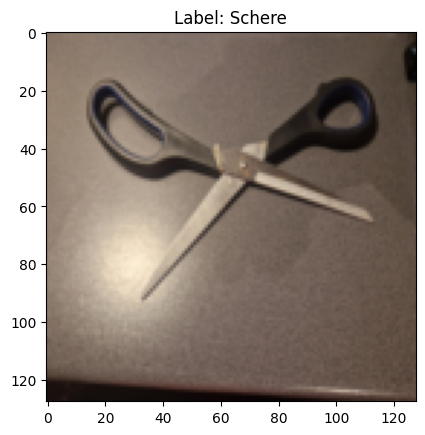

In [20]:
# Optional: Überprüfen, ob die Daten korrekt geladen wurden
class_names = test_data.classes
images, labels = next(iter(test_loader))
plt.imshow(images[0].permute(1, 2, 0))  # Permutieren für die Anzeige
plt.title(f"Label: {class_names[labels[0].item()]}")
plt.show()

In [21]:
# Check if CUDA is available
if torch.cuda.is_available():
    print(f"CUDA is available. GPU: {torch.cuda.get_device_name(0)}")
else:
    print("CUDA is not available.")

# Run a small test
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
x = torch.tensor([1.0, 2.0, 3.0], device=device)
print(f"Tensor on {device}: {x}")

CUDA is not available.
Tensor on cpu: tensor([1., 2., 3.])


In [22]:
def get_flatten_size(model, input_shape=(3, 128, 128)):
    with torch.no_grad():
        sample_input = torch.rand(1, *input_shape)  # Beispiel-Eingabe
        sample_output = model.cnn_relu_pool(sample_input)
        return sample_output.view(-1).shape[0]


In [23]:
class cnnNeuralnetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.cnn_relu_pool = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
                        
        )
        flatten_size = get_flatten_size(self, input_shape=(3, 128, 128))

        self.flatten = nn.Flatten()
        self.classification = nn.Sequential(
            nn.Linear(flatten_size, 128),  
            nn.ReLU(),
            
            nn.Linear(128, 4),
            nn.Dropout(p=0.25)

    
        )    
        
    def forward(self, x):
        x = self.cnn_relu_pool(x)
        x = self.flatten(x)
        x = self.classification(x)
        return x
    
model = cnnNeuralnetwork()
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


def train(dataloader, model, loss_func, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X,y) in enumerate(dataloader):
        X, y = X.to("cpu"), y.to("cpu")

        # Compute prediction error
        pred = model(X) # model(X) calls model.forward(x)
        loss = loss_func(pred, y) # Calculate error between prediction and ground truth

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Logging
        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f} [{current:>5d}/{size:>5d}]")


def test(dataloader, model, loss_func):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to("cpu"), y.to("cpu")
            pred = model(X)
            test_loss += loss_func(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    accuracy = 100*correct
    print(f"Test Error:\n\tAccuracy: {accuracy:>0.1f}%\n\tAvg loss: {test_loss:>8f}\n")
    return accuracy, test_loss



In [ ]:
epochs = 10
history = {
    "epoch": [],
    "accuracy": [],
    "loss": [],
}
for e in range(epochs):
  print(f"Epoch {e+1}\n", 40*"-")
  train(train_loader, model, loss_func, optimizer)
  acc, loss = test(val_loader, model, loss_func)

  history["epoch"].append(e)
  history["accuracy"].append(acc)
  history["loss"].append(loss)
print("Done!")

Epoch 1
 ----------------------------------------


## Speichern

In [ ]:

# Hyperparameter und Speicher für Trainingsergebnisse
epochs = 10
history = {
    "epoch": [],
    "accuracy": [],
    "loss": [],
}

# Checkpoints: Speichere das beste Modell basierend auf dem niedrigsten Validierungsverlust
best_loss = float("inf")  # Initialisiere mit einem großen Wert
checkpoint_path = "best_model.pth"

for e in range(epochs):
    print(f"Epoch {e+1}\n", 40*"-")
    
    # Training
    train(train_loader, model, loss_func, optimizer)
    
    # Validierung
    acc, loss = test(val_loader, model, loss_func)

    # Loggen der Ergebnisse
    history["epoch"].append(e)
    history["accuracy"].append(acc)
    history["loss"].append(loss)
    
    # Checkpoint speichern, wenn der Validierungsverlust besser ist
    if loss < best_loss:
        best_loss = loss
        torch.save({
            "epoch": e,
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "loss": loss,
        }, checkpoint_path)
        print(f"Checkpoint saved at epoch {e+1} with loss {loss:.4f}")

print("Done!")


Epoch 1
 ----------------------------------------
loss: 1.382560 [   32/  655]
Test Error:
	Accuracy: 28.0%
	Avg loss: 1.319903

Checkpoint saved at epoch 1 with loss 1.3199
Epoch 2
 ----------------------------------------
loss: 1.316124 [   32/  655]
Test Error:
	Accuracy: 50.0%
	Avg loss: 1.258676

Checkpoint saved at epoch 2 with loss 1.2587
Epoch 3
 ----------------------------------------
loss: 1.368077 [   32/  655]
Test Error:
	Accuracy: 40.2%
	Avg loss: 1.272804

Epoch 4
 ----------------------------------------
loss: 1.252748 [   32/  655]
Test Error:
	Accuracy: 36.6%
	Avg loss: 1.140092

Checkpoint saved at epoch 4 with loss 1.1401
Epoch 5
 ----------------------------------------
loss: 1.103430 [   32/  655]
Test Error:
	Accuracy: 51.8%
	Avg loss: 1.089461

Checkpoint saved at epoch 5 with loss 1.0895
Epoch 6
 ----------------------------------------
loss: 1.107542 [   32/  655]
Test Error:
	Accuracy: 51.8%
	Avg loss: 0.951801

Checkpoint saved at epoch 6 with loss 0.9518
E

In [ ]:
test(test_loader, model, loss_func)

Test Error:
	Accuracy: 100.0%
	Avg loss: 0.857919



(100.0, 0.8579185009002686)